In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Attention, Concatenate, Permute, Flatten
from keras.models import Model
from keras.optimizers import Nadam
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## IMPORTING DATA

In [ ]:
train_dataset = pd.read_csv('/content/drive/MyDrive/deep learning/SOLUSDT-5m-2020-08.csv')
test_dataset = pd.read_csv('/content/drive/MyDrive/deep learning/SOLUSDT-5m-2023-11.csv')
test_dataset2 = pd.read_csv('/content/drive/MyDrive/deep learning/SOLUSDT-5m-2023-08.csv')
test_dataset3 = pd.read_csv('/content/drive/MyDrive/deep learning/SOLUSDT-5m-2024-06-29.csv')

In [ ]:
new_header = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume', 'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'ignore']  # replace with actual column names

train_dataset.columns = new_header
test_dataset.columns = new_header
test_dataset2.columns = new_header
test_dataset3.columns = new_header

In [ ]:
print(train_dataset.head())

       open_time    open    high     low   close   volume     close_time  \
0  1597125900000  3.1846  3.4700  3.1846  3.1846  2282.99  1597126199999   
1  1597126200000  3.1655  3.1655  3.1655  3.1655   104.97  1597126499999   
2  1597126500000  3.1655  3.3564  3.1358  3.3564   237.93  1597126799999   
3  1597126800000  3.1993  3.3564  3.1500  3.1500  2308.50  1597127099999   
4  1597127100000  3.1360  3.1360  3.1360  3.1360   266.68  1597127399999   

   quote_volume  count  taker_buy_volume  taker_buy_quote_volume  ignore  
0   7313.194759     34           1162.73             3737.175189       0  
1    332.282535      2              0.00                0.000000       0  
2    782.552151      8             30.00              100.692000       0  
3   7428.434468     23           1985.96             6410.516452       0  
4    836.308480      8            106.68              334.548480       0  


In [ ]:
print(test_dataset.head())

       open_time   open   high    low  close    volume     close_time  \
0  1698797100000  38.19  38.36  38.16  38.20  37655.19  1698797399999   
1  1698797400000  38.19  38.21  38.13  38.18  35492.71  1698797699999   
2  1698797700000  38.17  38.22  38.12  38.17  25778.49  1698797999999   
3  1698798000000  38.17  38.29  37.93  37.99  50606.31  1698798299999   
4  1698798300000  38.00  38.06  37.90  38.02  28785.19  1698798599999   

   quote_volume  count  taker_buy_volume  taker_buy_quote_volume  ignore  
0  1.440564e+06   1991          19356.72             740518.0289       0  
1  1.354495e+06   1631           8905.38             339895.1898       0  
2  9.840173e+05   1268          10693.57             408213.9978       0  
3  1.928157e+06   2676          23086.81             880182.6440       0  
4  1.093509e+06   1515          13161.37             500048.4996       0  


In [ ]:
print(train_dataset.describe())

          open_time          open          high           low         close  \
count  2.377700e+04  23777.000000  23777.000000  23777.000000  23777.000000   
mean   1.633144e+12     37.905981     38.023865     37.787036     37.908626   
std    2.450893e+10     26.224209     26.336957     26.110346     26.228128   
min    1.597126e+12      2.750000      2.767000      2.743100      2.750000   
25%    1.598909e+12      4.679700      4.705100      4.655600      4.686200   
50%    1.629566e+12     38.653000     38.750000     38.579000     38.650000   
75%    1.660207e+12     44.080000     44.170000     43.993000     44.080000   
max    1.661990e+12    129.640000    130.110000    128.500000    129.640000   

              volume    close_time  quote_volume         count  \
count   23777.000000  2.377700e+04  2.377700e+04  23777.000000   
mean    13829.907411  1.633144e+12  7.351689e+05   1435.466459   
std     20220.655903  2.450893e+10  1.576485e+06   2996.609277   
min         0.000000  1.

In [ ]:
train_dataset['open_time'] = pd.to_datetime(train_dataset['open_time'], unit='ms')

In [ ]:
train_dataset['close_time'] = pd.to_datetime(train_dataset['close_time'], unit='ms')

In [ ]:
test_dataset['open_time'] = pd.to_datetime(test_dataset['open_time'], unit='ms')
test_dataset['close_time'] = pd.to_datetime(test_dataset['close_time'], unit='ms')

In [ ]:
test_dataset2['open_time'] = pd.to_datetime(test_dataset2['open_time'], unit='ms')
test_dataset2['close_time'] = pd.to_datetime(test_dataset2['close_time'], unit='ms')

In [ ]:
test_dataset3['open_time'] = pd.to_datetime(test_dataset3['open_time'], unit='ms')
test_dataset3['close_time'] = pd.to_datetime(test_dataset3['close_time'], unit='ms')

In [ ]:
print(test_dataset.describe())
print(test_dataset2.describe())
print(test_dataset3.describe())

                 open_time         open         high          low  \
count                 8639  8639.000000  8639.000000  8639.000000   
mean   2023-11-16 00:00:00    52.748597    52.899448    52.592610   
min    2023-11-01 00:05:00    37.930000    37.940000    37.810000   
25%    2023-11-08 12:02:30    43.410000    43.510000    43.300000   
50%    2023-11-16 00:00:00    56.280000    56.440000    56.110000   
75%    2023-11-23 11:57:30    58.390000    58.510000    58.260000   
max    2023-11-30 23:55:00    67.980000    68.200000    67.680000   
std                    NaN     7.809729     7.830461     7.787439   

             close         volume                     close_time  \
count  8639.000000    8639.000000                           8639   
mean     52.750881   30801.394316  2023-11-16 00:04:59.999000064   
min      37.920000    1477.750000     2023-11-01 00:09:59.999000   
25%      43.410000   12544.310000  2023-11-08 12:07:29.999000064   
50%      56.280000   21398.220000  202

In [ ]:
train_dataset = train_dataset[['open', 'high', 'low', 'close', 'volume']]
test_dataset = test_dataset[['open', 'high', 'low', 'close', 'volume']]
test_dataset2 = test_dataset2[['open', 'high', 'low', 'close', 'volume']]
test_dataset3 = test_dataset3[['open', 'high', 'low', 'close', 'volume']]

In [ ]:
print(train_dataset)

          open     high      low    close    volume
0       3.1846   3.4700   3.1846   3.1846   2282.99
1       3.1655   3.1655   3.1655   3.1655    104.97
2       3.1655   3.3564   3.1358   3.3564    237.93
3       3.1993   3.3564   3.1500   3.1500   2308.50
4       3.1360   3.1360   3.1360   3.1360    266.68
...        ...      ...      ...      ...       ...
23772  31.2500  31.3100  31.2200  31.2600   7148.67
23773  31.2700  31.3300  31.2100  31.3300   9407.72
23774  31.3300  31.4900  31.3200  31.4100  14913.91
23775  31.4100  31.5200  31.4100  31.4700   6139.80
23776  31.4700  31.5200  31.4500  31.5000   3435.75

[23777 rows x 5 columns]


In [ ]:
print(test_dataset)
print(test_dataset2)
print(test_dataset3)

       open   high    low  close    volume
0     38.19  38.36  38.16  38.20  37655.19
1     38.19  38.21  38.13  38.18  35492.71
2     38.17  38.22  38.12  38.17  25778.49
3     38.17  38.29  37.93  37.99  50606.31
4     38.00  38.06  37.90  38.02  28785.19
...     ...    ...    ...    ...       ...
8634  59.14  59.15  59.05  59.13   9943.73
8635  59.12  59.24  59.10  59.21  10418.43
8636  59.20  59.28  59.13  59.25   9093.09
8637  59.25  59.26  59.16  59.23   7345.34
8638  59.24  59.31  59.19  59.30   8782.49

[8639 rows x 5 columns]
       open   high    low  close    volume
0     23.70  23.70  23.59  23.66  14283.06
1     23.66  23.74  23.65  23.74  12895.14
2     23.74  23.76  23.71  23.75   4234.83
3     23.74  23.81  23.74  23.78   5957.77
4     23.77  23.83  23.77  23.83   9189.76
...     ...    ...    ...    ...       ...
8922  19.74  19.77  19.74  19.75   1709.32
8923  19.76  19.76  19.74  19.76   1618.06
8924  19.75  19.75  19.71  19.72   5554.12
8925  19.73  19.74  19.71  19

In [ ]:
print(train_dataset.describe())

               open          high           low         close         volume
count  23777.000000  23777.000000  23777.000000  23777.000000   23777.000000
mean      37.905981     38.023865     37.787036     37.908626   13829.907411
std       26.224209     26.336957     26.110346     26.228128   20220.655903
min        2.750000      2.767000      2.743100      2.750000       0.000000
25%        4.679700      4.705100      4.655600      4.686200    4096.130000
50%       38.653000     38.750000     38.579000     38.650000    7780.990000
75%       44.080000     44.170000     43.993000     44.080000   15399.797000
max      129.640000    130.110000    128.500000    129.640000  347960.155000


## PREPROCESSING DATA

In [ ]:
null_values = train_dataset.isnull().sum()

print(null_values)

open      0
high      0
low       0
close     0
volume    0
dtype: int64


In [ ]:
print(train_dataset.dtypes)

open      float64
high      float64
low       float64
close     float64
volume    float64
dtype: object


In [ ]:
features = ["open", "high", "low", "close", "volume"]

In [ ]:
scaler = MinMaxScaler()

In [ ]:
train_scaled = scaler.fit_transform(train_dataset[features])
test_scaled = scaler.transform(test_dataset[features])
test_scaled2 = scaler.transform(test_dataset2[features])
test_scaled3 = scaler.transform(test_dataset3[features])

In [ ]:
print(train_scaled)

[[0.00342501 0.00552052 0.00351074 0.00342501 0.00656107]
 [0.00327449 0.00312934 0.00335886 0.00327449 0.00030167]
 [0.00327449 0.00462844 0.00312269 0.00477894 0.00068379]
 ...
 [0.22523446 0.22555618 0.22723922 0.22586492 0.04286097]
 [0.22586492 0.22579176 0.22795489 0.22633777 0.01764512]
 [0.22633777 0.22579176 0.22827296 0.2265742  0.00987398]]


In [ ]:
print(test_scaled)
print(test_scaled2)
print(test_scaled3)

[[0.27929703 0.27950496 0.28162987 0.27937584 0.10821696]
 [0.27929703 0.27832704 0.28139132 0.27921822 0.10200222]
 [0.27913941 0.27840557 0.2813118  0.27913941 0.0740846 ]
 ...
 [0.44487351 0.44378568 0.44838017 0.44526755 0.02613256]
 [0.44526755 0.44362863 0.44861872 0.44510994 0.02110972]
 [0.44518875 0.44402127 0.44885728 0.4456616  0.02523993]]
[[0.16510363 0.16438281 0.16577142 0.1647884  0.04104798]
 [0.1647884  0.16469692 0.16624853 0.16541887 0.03705924]
 [0.16541887 0.16485398 0.16672564 0.16549768 0.01217045]
 ...
 [0.13397431 0.13336422 0.13491824 0.13373788 0.01596194]
 [0.13381669 0.13328569 0.13491824 0.1338955  0.00474129]
 [0.1338955  0.13328569 0.13499776 0.1338955  0.00529888]]
[[1.08322169 1.08017716 1.09176435 1.08385216 0.01620183]
 [1.08385216 1.08174772 1.09359327 1.08511309 0.01241894]
 [1.08511309 1.08166919 1.09216194 1.0823548  0.01629737]
 ...
 [1.08385216 1.07986305 1.09192339 1.0823548  0.00409708]
 [1.08227599 1.07892071 1.09120772 1.0824336  0.0055594

In [ ]:
def create_time_series(data, look_back=6):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

In [ ]:
look_back = 6
X_train, y_train = create_time_series(train_scaled, look_back)
X_test, y_test = create_time_series(test_scaled, look_back)

In [ ]:
X_test2, y_test2 = create_time_series(test_scaled2, look_back)
X_test3, y_test3 = create_time_series(test_scaled3, look_back)

In [ ]:
print(X_test)

[[[0.27929703 0.27950496 0.28162987 0.27937584 0.10821696]
  [0.27929703 0.27832704 0.28139132 0.27921822 0.10200222]
  [0.27913941 0.27840557 0.2813118  0.27913941 0.0740846 ]
  [0.27913941 0.27895526 0.27980095 0.27772086 0.14543708]
  [0.27779967 0.27714912 0.27956239 0.27795729 0.08272554]
  [0.27787848 0.27785587 0.28019854 0.27882418 0.08209541]]

 [[0.27929703 0.27832704 0.28139132 0.27921822 0.10200222]
  [0.27913941 0.27840557 0.2813118  0.27913941 0.0740846 ]
  [0.27913941 0.27895526 0.27980095 0.27772086 0.14543708]
  [0.27779967 0.27714912 0.27956239 0.27795729 0.08272554]
  [0.27787848 0.27785587 0.28019854 0.27882418 0.08209541]
  [0.27882418 0.27895526 0.28139132 0.27961226 0.08083762]]

 [[0.27913941 0.27840557 0.2813118  0.27913941 0.0740846 ]
  [0.27913941 0.27895526 0.27980095 0.27772086 0.14543708]
  [0.27779967 0.27714912 0.27956239 0.27795729 0.08272554]
  [0.27787848 0.27785587 0.28019854 0.27882418 0.08209541]
  [0.27882418 0.27895526 0.28139132 0.27961226 0.080

In [ ]:
num_elements = X_test.size
print("Number of elements:", num_elements)

Number of elements: 258990


In [ ]:
num_elements = X_test2.size
print("Number of elements:", num_elements)

Number of elements: 267630


In [ ]:
num_elements = X_test3.size
print("Number of elements:", num_elements)

Number of elements: 8430


In [ ]:
num_elements = y_test.size
print("Number of elements:", num_elements)

Number of elements: 43165


In [ ]:
num_elements = y_test2.size
print("Number of elements:", num_elements)

Number of elements: 44605


In [ ]:
num_elements = y_test3.size
print("Number of elements:", num_elements)

Number of elements: 1405


In [ ]:
print(y_train)

[[0.00197179 0.00195613 0.00181223 0.00193002 0.01090536]
 [0.00174955 0.00205586 0.00129059 0.0017062  0.00285444]
 [0.00199622 0.00185562 0.00181382 0.00199543 0.00056176]
 ...
 [0.22523446 0.22555618 0.22723922 0.22586492 0.04286097]
 [0.22586492 0.22579176 0.22795489 0.22633777 0.01764512]
 [0.22633777 0.22579176 0.22827296 0.2265742  0.00987398]]


In [ ]:
num_elements = y_train.size
print("Number of elements:", num_elements)

Number of elements: 118855


In [ ]:
print(X_train)

[[[0.00342501 0.00552052 0.00351074 0.00342501 0.00656107]
  [0.00327449 0.00312934 0.00335886 0.00327449 0.00030167]
  [0.00327449 0.00462844 0.00312269 0.00477894 0.00068379]
  [0.00354086 0.00462844 0.00323561 0.00315234 0.00663438]
  [0.003042   0.00289769 0.00312428 0.003042   0.00076641]
  [0.003042   0.00289769 0.00204522 0.00197257 0.01270197]]

 [[0.00327449 0.00312934 0.00335886 0.00327449 0.00030167]
  [0.00327449 0.00462844 0.00312269 0.00477894 0.00068379]
  [0.00354086 0.00462844 0.00323561 0.00315234 0.00663438]
  [0.003042   0.00289769 0.00312428 0.003042   0.00076641]
  [0.003042   0.00289769 0.00204522 0.00197257 0.01270197]
  [0.00197179 0.00195613 0.00181223 0.00193002 0.01090536]]

 [[0.00327449 0.00462844 0.00312269 0.00477894 0.00068379]
  [0.00354086 0.00462844 0.00323561 0.00315234 0.00663438]
  [0.003042   0.00289769 0.00312428 0.003042   0.00076641]
  [0.003042   0.00289769 0.00204522 0.00197257 0.01270197]
  [0.00197179 0.00195613 0.00181223 0.00193002 0.010

In [ ]:
num_elements = X_train.size
print("Number of elements:", num_elements)

Number of elements: 713130


## LSTM ATTENTION

In [ ]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
inputs = Input(shape=(look_back, len(features)))
lstm_out = LSTM(75, return_sequences=True)(inputs)
attention = Attention()([lstm_out, lstm_out])
attention = Flatten()(attention)
dense_out = Dense(len(features))(attention)
model = Model(inputs, dense_out)

In [ ]:
model.compile(loss="mean_squared_error", optimizer="adam")

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Epoch 1/20
595/595 [==============================] - 6s 5ms/step - loss: 0.0023 - val_loss: 2.7389e-04 - lr: 0.0010
Epoch 2/20
595/595 [==============================] - 3s 4ms/step - loss: 4.8394e-04 - val_loss: 2.5774e-04 - lr: 0.0010
Epoch 3/20
595/595 [==============================] - 3s 5ms/step - loss: 4.7302e-04 - val_loss: 2.5378e-04 - lr: 0.0010
Epoch 4/20
595/595 [==============================] - 3s 6ms/step - loss: 4.6053e-04 - val_loss: 2.7203e-04 - lr: 0.0010
Epoch 5/20
595/595 [==============================] - 3s 6ms/step - loss: 4.4487e-04 - val_loss: 2.3719e-04 - lr: 0.0010
Epoch 6/20
595/595 [==============================] - 3s 4ms/step - loss: 4.1617e-04 - val_loss: 2.4738e-04 - lr: 0.0010
Epoch 7/20
595/595 [==============================] - 3s 5ms/step - loss: 4.1858e-04 - val_loss: 2.4763e-04 - lr: 0.0010
Epoch 8/20
595/595 [==============================] - 3s 5ms/step - loss: 4.0496e-04 - val_loss: 2.2360e-04 - lr: 0.0010
Epoch 9/20
595/595 [================

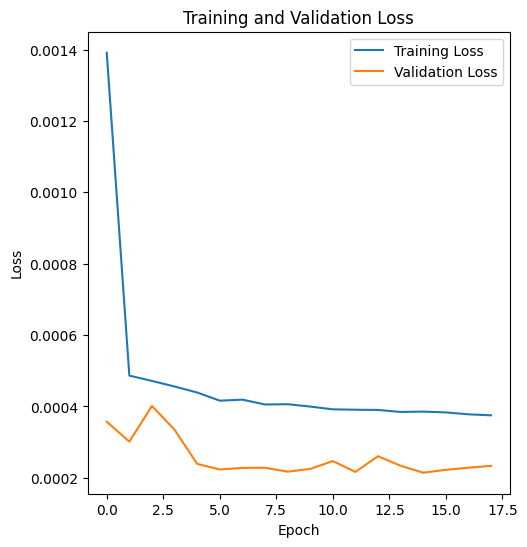

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
y_pred = model.predict(X_test)

270/270 [==============================] - 1s 3ms/step


In [ ]:
y_pred2 = model.predict(X_test2)

279/279 [==============================] - 1s 4ms/step


In [ ]:
y_pred3 = model.predict(X_test3)

9/9 [==============================] - 0s 2ms/step


In [ ]:
y_pred_denormalized = scaler.inverse_transform(y_pred)
y_test_denormalized = scaler.inverse_transform(y_test)

In [ ]:
y_pred_denormalized2 = scaler.inverse_transform(y_pred2)
y_test_denormalized2 = scaler.inverse_transform(y_test2)

In [ ]:
y_pred_denormalized3 = scaler.inverse_transform(y_pred3)
y_test_denormalized3 = scaler.inverse_transform(y_test3)

In [ ]:
print(y_pred_denormalized)

[[   38.18685     38.309788    37.96327     38.0476   32685.43    ]
 [   38.18809     38.287334    37.966866    38.0545   31103.549   ]
 [   38.225864    38.32075     37.999924    38.105686 32752.393   ]
 ...
 [   59.147305    59.22292     58.999977    59.058628 18658.361   ]
 [   59.158974    59.23818     59.046444    59.08137  16116.99    ]
 [   59.164562    59.239174    59.073746    59.095985 14194.372   ]]


In [ ]:
print(y_pred_denormalized2)

[[2.37113457e+01 2.37290497e+01 2.36840687e+01 2.36846313e+01
  1.08276875e+04]
 [2.38763885e+01 2.39656067e+01 2.38393307e+01 2.39106712e+01
  2.11859688e+04]
 [2.37717438e+01 2.38958511e+01 2.37819881e+01 2.37480431e+01
  1.54273887e+04]
 ...
 [1.96744576e+01 1.96897697e+01 1.97001667e+01 1.96631927e+01
  4.60326416e+03]
 [1.96851845e+01 1.97000008e+01 1.97039165e+01 1.96815529e+01
  5.78014307e+03]
 [1.96616459e+01 1.96777172e+01 1.96834240e+01 1.96539211e+01
  5.36290283e+03]]


In [ ]:
print(y_pred_denormalized3)

[[  128.44684   128.99352   127.74653   127.83226 50057.77   ]
 [  128.78877   129.34616   128.07246   128.13704 55433.562  ]
 [  128.88054   129.50565   128.22975   128.2773  47174.867  ]
 ...
 [  201.46893   202.85034   200.82968   199.4379  42834.945  ]
 [  201.92358   203.173     201.29695   199.73546 53946.97   ]
 [  201.86026   203.33527   201.25761   199.77481 42277.96   ]]


In [ ]:
num_elements = y_pred_denormalized.size
print("Number of elements:", num_elements)

Number of elements: 43165


In [ ]:
print(y_test_denormalized)

[[   38.13    38.29    38.13    38.23 28128.27]
 [   38.24    38.36    38.14    38.24 33621.76]
 [   38.23    38.53    38.23    38.53 32449.12]
 ...
 [   59.2     59.28    59.13    59.25  9093.09]
 [   59.25    59.26    59.16    59.23  7345.34]
 [   59.24    59.31    59.19    59.3   8782.49]]


In [ ]:
num_elements = y_test_denormalized.size
print("Number of elements:", num_elements)

Number of elements: 43165


TEST SET 1

In [ ]:
mae = mean_absolute_error(y_test_denormalized, y_pred_denormalized)
rmse = np.sqrt(mean_squared_error(y_test_denormalized, y_pred_denormalized))
mda = np.mean(np.abs((y_test_denormalized - y_pred_denormalized) / y_test_denormalized)) * 100

In [ ]:
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MDA: {mda:.2f}%")

MAE: 2613.05
RMSE: 10373.57
MDA: 11.99%


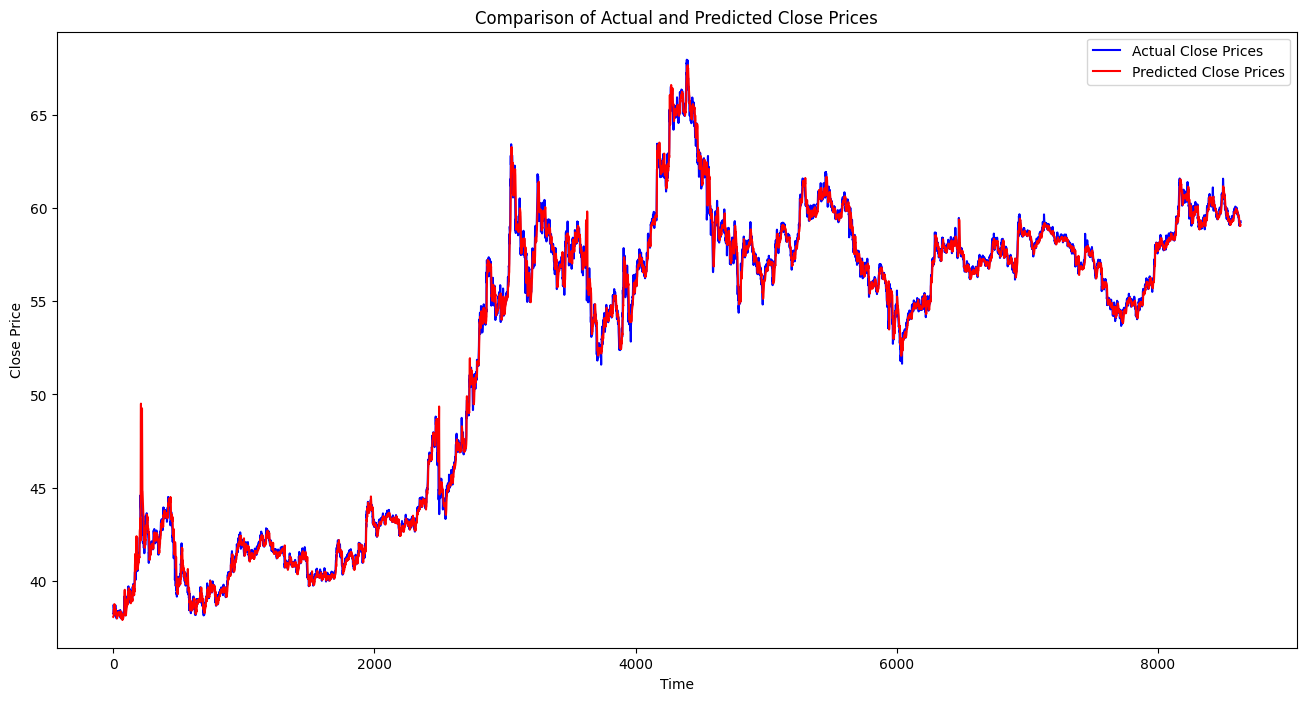

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_test_denormalized[:, 3], color='blue', label='Actual Close Prices')

plt.plot(y_pred_denormalized[:, 3], color='red', label='Predicted Close Prices')

plt.title('Comparison of Actual and Predicted Close Prices')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

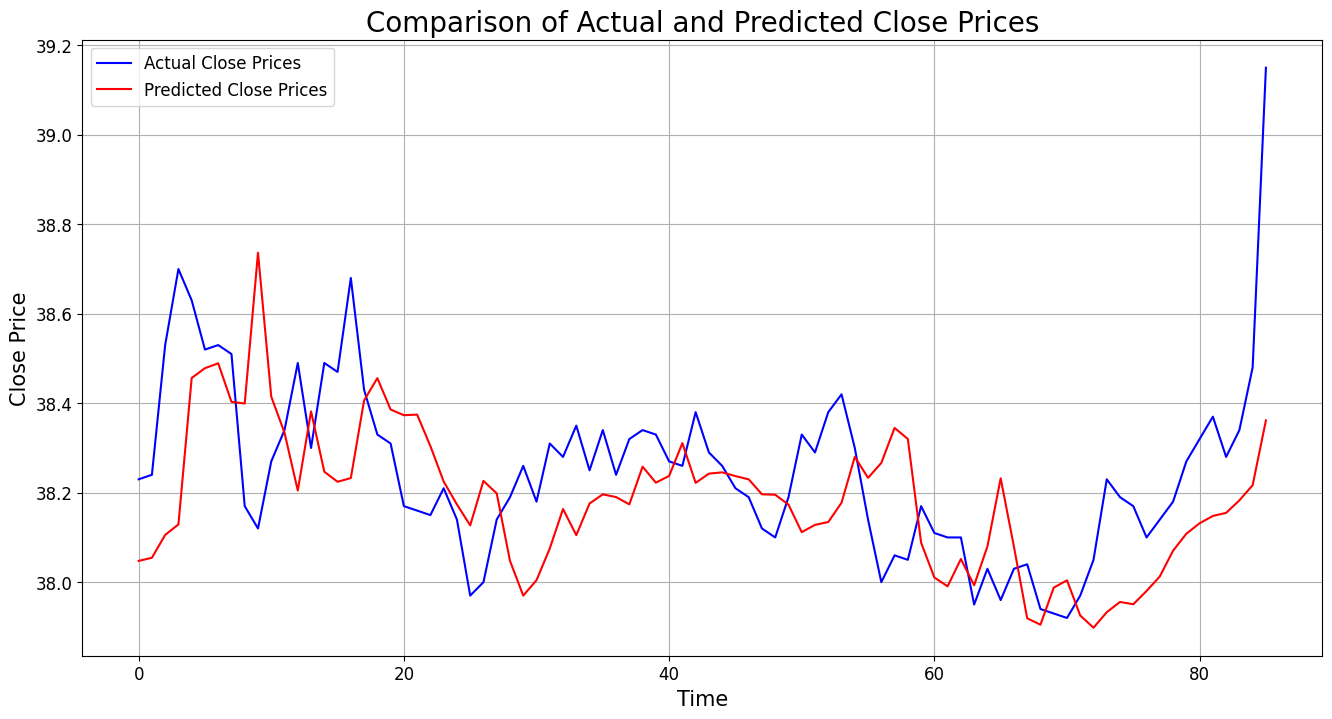

In [ ]:
data_length = len(y_test_denormalized)
num_points = max(1, int(data_length * 0.01))

y_test_denormalized = y_test_denormalized[:num_points]
y_pred_denormalized = y_pred_denormalized[:num_points]

plt.figure(figsize=(16, 8))

plt.plot(y_test_denormalized[:, 3], color='blue', label='Actual Close Prices')

plt.plot(y_pred_denormalized[:, 3], color='red', label='Predicted Close Prices')

plt.title('Comparison of Actual and Predicted Close Prices', fontsize=20)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Close Price', fontsize=15)
plt.legend(fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.show()

TEST SET 2

In [ ]:
mae = mean_absolute_error(y_test_denormalized2, y_pred_denormalized2)
rmse = np.sqrt(mean_squared_error(y_test_denormalized2, y_pred_denormalized2))
mda = np.mean(np.abs((y_test_denormalized2 - y_pred_denormalized2) / y_test_denormalized2)) * 100
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MDA: {mda:.2f}%")

MAE: 1494.00
RMSE: 7937.32
MDA: 30.59%


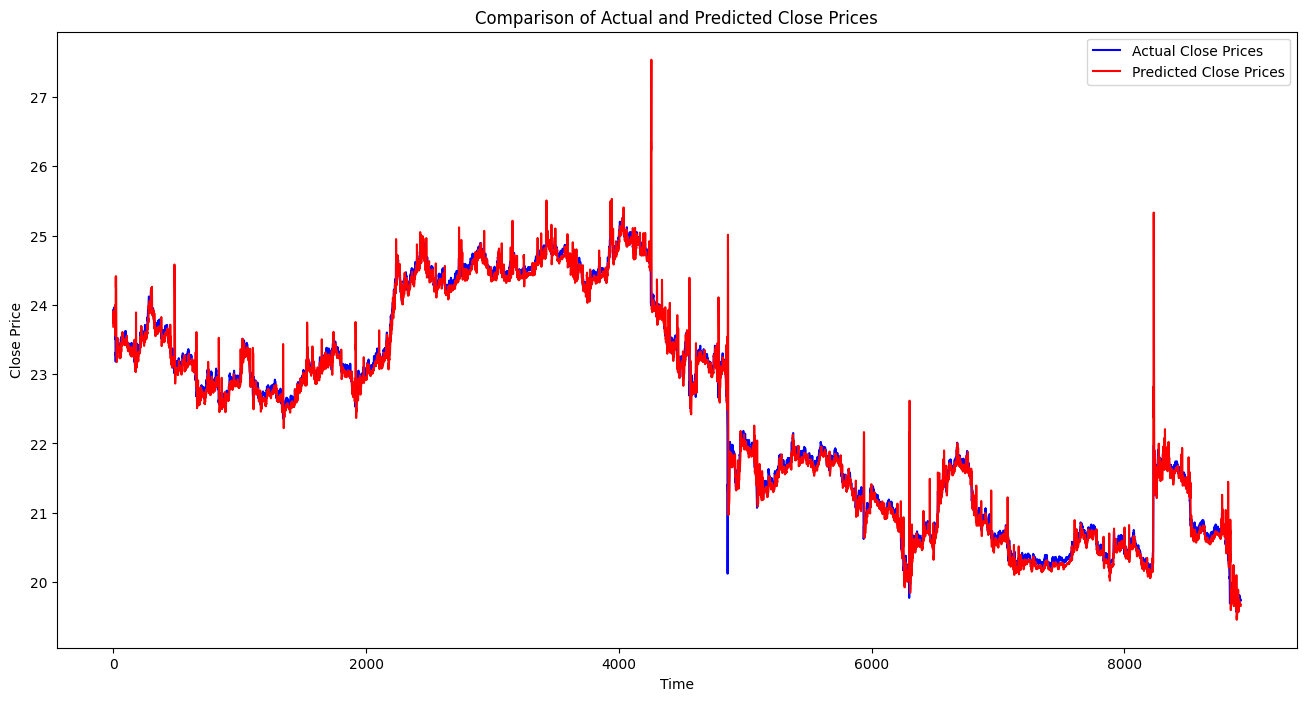

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_test_denormalized2[:, 3], color='blue', label='Actual Close Prices')

plt.plot(y_pred_denormalized2[:, 3], color='red', label='Predicted Close Prices')

plt.title('Comparison of Actual and Predicted Close Prices')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

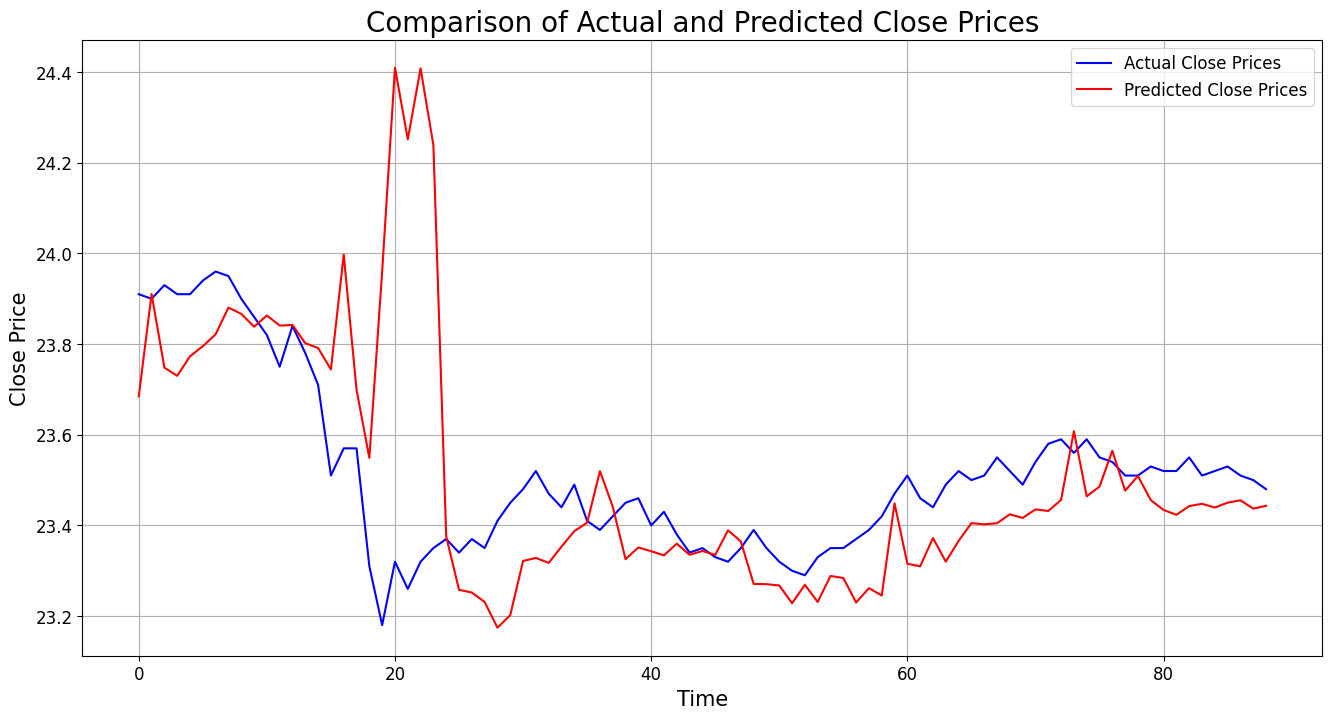

In [ ]:
data_length = len(y_test_denormalized2)
num_points = max(1, int(data_length * 0.01))

y_test_denormalized2 = y_test_denormalized2[:num_points]
y_pred_denormalized2 = y_pred_denormalized2[:num_points]

plt.figure(figsize=(16, 8))

plt.plot(y_test_denormalized2[:, 3], color='blue', label='Actual Close Prices')

plt.plot(y_pred_denormalized2[:, 3], color='red', label='Predicted Close Prices')

plt.title('Comparison of Actual and Predicted Close Prices', fontsize=20)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Close Price', fontsize=15)
plt.legend(fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.show()

TEST SET 3

In [ ]:
mae = mean_absolute_error(y_test_denormalized3, y_pred_denormalized3)
rmse = np.sqrt(mean_squared_error(y_test_denormalized3, y_pred_denormalized3))
mda = np.mean(np.abs((y_test_denormalized3 - y_pred_denormalized3) / y_test_denormalized3)) * 100
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MDA: {mda:.2f}%")

MAE: 1187.30
RMSE: 3073.03
MDA: 39.34%


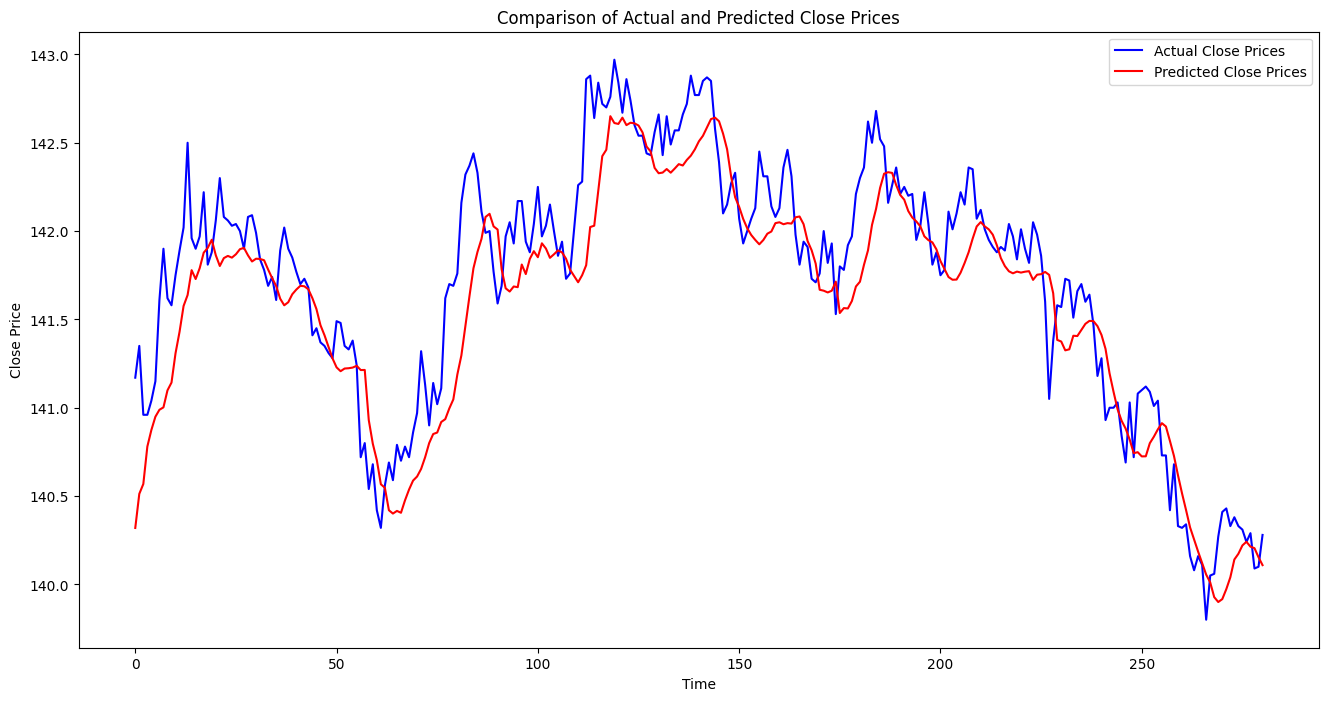

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_test_denormalized3[:, 3], color='blue', label='Actual Close Prices')

plt.plot(y_pred_denormalized3[:, 3], color='red', label='Predicted Close Prices')

plt.title('Comparison of Actual and Predicted Close Prices')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

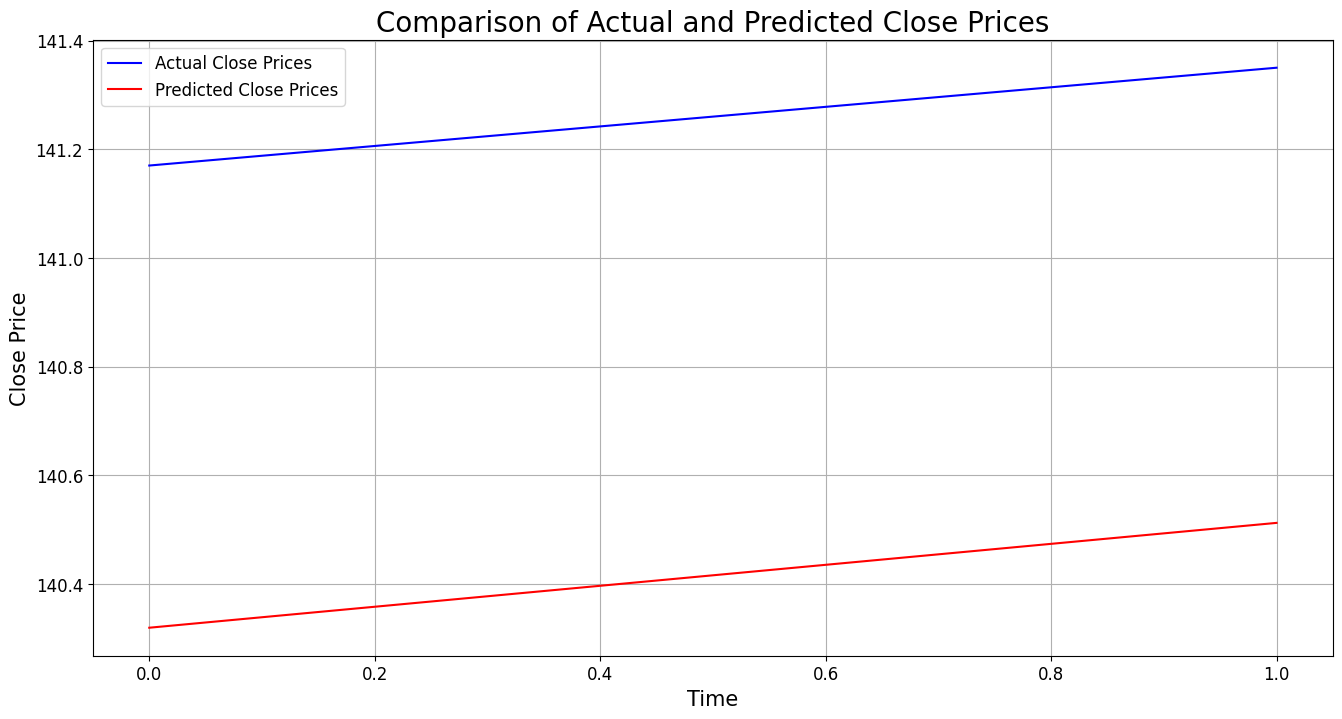

In [ ]:
data_length = len(y_test_denormalized3)
num_points = max(1, int(data_length * 0.01))

y_test_denormalized3 = y_test_denormalized3[:num_points]
y_pred_denormalized3 = y_pred_denormalized3[:num_points]

plt.figure(figsize=(16, 8))

plt.plot(y_test_denormalized3[:, 3], color='blue', label='Actual Close Prices')

plt.plot(y_pred_denormalized3[:, 3], color='red', label='Predicted Close Prices')

plt.title('Comparison of Actual and Predicted Close Prices', fontsize=20)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Close Price', fontsize=15)
plt.legend(fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.show()